## Code is split into 4 sections: Data pre-processing, Clustering , 1D CNN and 2D CNN 

## 1. Data pre-processing

In [3]:
#Basic imports for data extractions and clustering

import xml.etree.cElementTree as et
import pandas as pd
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

In [4]:
#Extract from xml - A1

def extract_xml(xmlfile):
    
    tree = et.parse(xmlfile)
    root = tree.getroot()
    headline = root.find("headline").text                       #extracting headline
    text = root.find("text") 
    
    rtext = ""
    for child in text.iter('p'): 
        rtext = rtext + child.text + '. '                       #extracting the main text part of newsitems
    
    biptopics = ""
    for codes in root.iter('codes'):                            #iterating codes then
        if(codes.attrib['class'] == 'bip:topics:1.0'):  
            for code in codes:                                  #iterating on bip:topics to find the topics    
                biptopics = code.attrib['code']
                break
    
    for dc in root.iter('dc'):
        if(dc.attrib['element'] == 'dc.date.published'):        #finding dc date published
            dcdate = dc.attrib['value']

    if (root.attrib['itemid']) is not None:                     #finding itemid             
        itemid = root.attrib['itemid'] 
        
    head,tail = os.path.split(xmlfile)
    filename = tail
    
    rows=[]                                                     #storing obtained values in dataframe
    rows.append({"headline": headline, "text": rtext, "biptopics": biptopics, "dcdate": dcdate,"itemid":itemid,"filename":filename})
    cols = ["headline", "text", "biptopics", "dcdate","itemid","filename"] # columns in dataframe
    out_df = pd.DataFrame(rows, columns = cols)                 #dataframe
    
    return out_df         

df = pd.DataFrame()
path = os.path.expanduser("~/Desktop/Project/data/*.xml")
for fname in glob.glob(path):
    df = pd.concat([df,extract_xml(fname)],ignore_index=True)

In [5]:
frame = df[['headline', 'text', 'biptopics','itemid']].copy() #keeping a copy of the original dataframe for later

In [6]:
''' This section is to preprocess all the text'''
import re, string, unicodedata
import nltk
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize

stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")

#remove html tags if any
def strip_html(text): 
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#remove between square brackets if any
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#remove extra white spaces if any
def remove_extra_white_spaces(text):
    return re.sub(' +', ' ', text)

#cleaning noise from text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_extra_white_spaces(text)
    return text

#tokenizer
def tokenize_text(text):
    # first tokenize by sentence, then by word
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filtering out any tokens not containing letters
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

#Remove stop words from list of tokenized words
def remove_stopwords(words):
    
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

#Remove custom stop words from list of tokenized words
def remove_custom_stopwords(words):
    
    new_words = []
    stopwrds = ['c','said','b','l','percent','million','billion','new','would','year','u','har','w','v','p','n','h']
    for word in words:
        if word not in stopwrds:
            new_words.append(word)
    return new_words

#lemmatization
def lemmatize_words(text):
    return [lemmatizer.lemmatize(w) for w in text]

#stemming - preferred method for clustering
def stem_words(text):
    stems = [stemmer.stem(t) for t in text]
    return stems

#base return function as tokenizer so tf-idf vectorizer doesn't change/interfere with tokens
def identity_tokenizer(text):
    return text

df["text"] = df["text"].astype(str).str.lower()                                   #to lower case
df["text"] = df["text"].astype(str).str.replace('[^\w\s]','')                     #remove punctuation
df["text"] = df["text"].str.replace('\d+', '')                                    #remove numbers
df["text"] = df["text"].str.replace('\t','', regex=True)                          #remove \t in some files
df["text"] = df["text"].apply(denoise_text)                                       #clean noise from text
df["text"] = df["text"].apply(tokenize_text)                                      #tokenized into words
df["text"] = df["text"].apply(remove_stopwords)                                   #stopwords removal
df["text"] = df["text"].apply(remove_custom_stopwords)                            #custom stopwords removal
df["text"] = df["text"].apply(stem_words)                                         #stemming
df

,headline,text,biptopics,dcdate,itemid,filename
0,Canadian Occidental mounts rival Wascana bid.,"[canadian, occident, petroleum, ltd, emerg, tu...",C181,1997-03-18,326914,326914newsML.xml
1,"Gruma, Maseca to receive syndicated loan - bank.","[bank, america, launch, threeyear, syndic, loa...",C173,1997-03-18,326915,326915newsML.xml
2,Too early to call Krupp bid hostile - Deutsche...,"[deutsch, bank, ag, manag, board, member, rolf...",C18,1997-03-18,326916,326916newsML.xml
3,"FOCUS - Euro bourses fret over Wall St, electi...","[european, bours, fell, tuesday, even, wall, s...",M11,1997-03-18,326917,326917newsML.xml
4,"French stocks fall, Alcatel posts big gain.","[french, share, close, lower, tuesday, second,...",G152,1997-03-18,326918,326918newsML.xml
...,...,...,...,...,...,...
48370,U.S. to back fewer supercomputer centers - Times.,"[nation, scienc, foundat, plan, reduc, number,...",,1997-03-31,477881,477881newsML.xml
48371,Indian shares plunge 8.6 pct on political crisis.,"[indian, share, plung, eight, panicki, trade, ...",M11,1997-03-31,477882,477882newsML.xml
48372,"Singapore shares open weak, funds stay sidelined.","[singapor, share, open, weaker, monday, fund, ...",M11,1997-03-31,477883,477883newsML.xml
48373,Selecta declares two centavo cash dividend.,"[selecta, dairi, product, inc, declar, monday,...",C151,1997-03-31,477884,477884newsML.xml


In [7]:
#tfidf
tfidf = TfidfVectorizer(
    min_df = 0.01,
    max_df = 0.60,
    max_features = 1100,
    tokenizer=identity_tokenizer, 
    lowercase=False,
    ngram_range=(1,3)
)
tfidf.fit(df['text'].values)
text = tfidf.transform(df['text'].values)


%time tfidf_matrix = tfidf.fit_transform(df['text'].values) 
print(tfidf_matrix.shape)
terms = tfidf.get_feature_names()
print(terms)

Wall time: 39.4 s
(48375, 1100)
['abl', 'accept', 'access', 'accord', 'account', 'accus', 'achiev', 'acquir', 'acquisit', 'across', 'act', 'action', 'activ', 'actual', 'ad', 'addit', 'adjust', 'administr', 'advanc', 'affair', 'affect', 'africa', 'african', 'afternoon', 'ag', 'agenc', 'ago', 'agre', 'agreement', 'agricultur', 'ahead', 'aid', 'aim', 'air', 'airlin', 'airport', 'albania', 'albanian', 'alleg', 'allianc', 'allow', 'almost', 'along', 'alreadi', 'also', 'although', 'america', 'american', 'amid', 'among', 'amount', 'analyst', 'announc', 'annual', 'anoth', 'appeal', 'appear', 'appoint', 'approv', 'april', 'arab', 'area', 'arm', 'armi', 'around', 'arrest', 'arriv', 'asia', 'asian', 'ask', 'asset', 'assist', 'associ', 'attack', 'attempt', 'attract', 'auction', 'august', 'australia', 'australian', 'author', 'avail', 'averag', 'award', 'away', 'back', 'bad', 'balanc', 'ban', 'bank', 'barrel', 'base', 'basi', 'basi point', 'beat', 'becom', 'began', 'begin', 'behind', 'beij', 'belgia

## 2. Clustering

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters
Fit 22 clusters
Fit 24 clusters
Fit 26 clusters
Fit 28 clusters
Fit 30 clusters


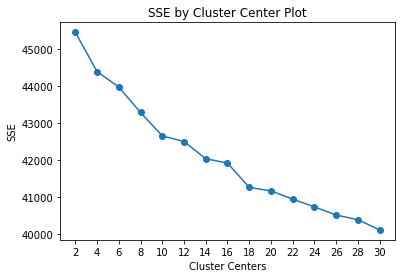

In [8]:
#Finding optimal value for K in Mini Batch Kmeans using Elbow curve
def find_optimal_clusters_elbow(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))

    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters_elbow(text, 30)

In [9]:
#Finding optimal value for K in Mini Batch Kmeans using Silhouette Score

from sklearn.metrics import silhouette_score

def find_optimal_clusters_silhouette(data, max_k):
    iters = range(2, max_k+1, 2)
    for j in iters:
        kmb = MiniBatchKMeans(n_clusters=j, init_size=1024, batch_size=2048, random_state=20).fit(data)
        label = kmb.labels_
        sil_coeff = silhouette_score(text, label, metric='euclidean')
        print("For cluster={}, The Silhouette Coefficient = {}".format(j, sil_coeff))
find_optimal_clusters_silhouette(text, 30)

In [10]:
#Clustering using MiniBatchKMeans using K from above methods
#I used Elbow method, silhouette score and visualized clusters on TSNE to identify value or K and quality of clusters.

K = 18
def mini_batch_kmeans(data, k):
    clusters = MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit_predict(data)
    return clusters
clusters = mini_batch_kmeans(text, K)

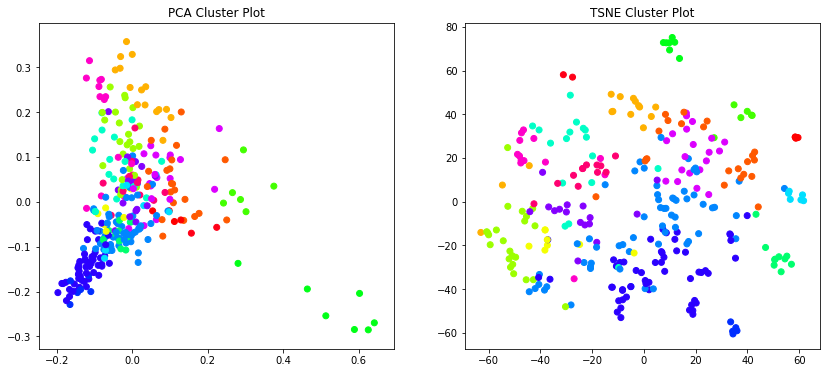

In [11]:
#Plot PCA and TSNE to visualize clusters

def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(text, clusters)
    

In [12]:
#Top keywords for each clusters for better understanding

def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(text, clusters, tfidf.get_feature_names(), 10)


Cluster 0
note,name,full,march,april,record,quarter,pay,amount,latest

Cluster 1
result,newsroom,dividend,sharehold,net,franc,group,compani,profit,share

Cluster 2
broker,stock exchang,exchang,close,market,trade,point,index,share,stock

Cluster 3
crop,may,import,grain,trader,price,soybean,export,wheat,tonn

Cluster 4
may,trade,market,per,crude,barrel,oil,trader,price,cent

Cluster 5
end,except,shr,net incom,per,per share,share,loss,incom,net

Cluster 6
shr,pretax,note,dividend,net,unless state,unless,profit,profit vs,vs

Cluster 7
score,divis,leagu,team,first,game,second,cup,play,match

Cluster 8
reserv,fix,loan,money,newsroom,market,central,central bank,rate,bank

Cluster 9
compani,share,chines,properti,ltd,china,hk,hong kong,hong,kong

Cluster 10
industri,oper,product,servic,unit,corp,market,plan,group,compani

Cluster 11
arab,presid,jerusalem,peac,nato,russia,yeltsin,palestinian,isra,israel

Cluster 12
rebel,state,offici,presid,countri,peopl,polic,parti,minist,govern

Cluster 13
pr

In [13]:
#Assign cluster Id to dataframe rows

clustnums = []
for i in clusters:
    clustnums.append(i)
frame['cluster'] = clustnums
frame = frame.filter(['text','biptopics','cluster'], axis=1)
frame = frame.rename(columns={"text": "post", "biptopics": "tags"})
frame = frame[frame.astype(str)['tags'] != ''] 

In [14]:
#Saving each cluster as a separate csv for faster and separate tests/runs later with 1D and 2D CNN
for k in range(0,K):
    dataframe = frame.loc[frame['cluster'] == k]
    dataframe = dataframe.filter(['post','tags'], axis=1)
    dataframe.to_csv (r'~/Desktop/Project/Clusters/dataframe%s.csv'%k, index = None, header=True)

In [15]:
#------------------------------------------------------------------------------#

## 3. 1D CNN

In [17]:
#------------------------------------------------------------------------------#

In [18]:
from collections import defaultdict

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten , Concatenate
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.models import Model

Using TensorFlow backend.


In [19]:
# Define some Global Variables
Max_len = 1000 # No of words in question we want to create a sequence with
Max_features = 10000 # Maximum Number of words we want to include in our dictionary
Embed_size = 100 # Size of word to vec embedding we are using
data_split = 0.2

In [20]:
#load data from one of the clusters 

data = pd.read_csv('Clusters/dataframe12.csv')


In [21]:
#total number of distinct tags in the cluster
datatags = list(set(data['tags']))
count = 0
for i in datatags:
    count = count+1
print(count)

#Define loss function as 'sparse_categorical_crossentropy' for good clusters with single tags

if(count>1):
    lossfunction = 'categorical_crossentropy'
else:
    lossfunction = 'sparse_categorical_crossentropy'

51


In [22]:
#basic noise cleaning to prepare text for word embeddings
def denoise_text(string):
    
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)
    string = re.sub(r"\"", "", string)
    string = unicodedata.normalize('NFKD', string).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    string = re.sub(r'[^\w\s]', '', string)  
    string = re.sub(r'\d+', '', string)
    string = re.sub(r'\t', '', string)
    return string.strip().lower()

texts = []
labels = []

for i in range(data.post.shape[0]):
    text = BeautifulSoup(data.post[i])
    texts.append(denoise_text(text.get_text()))
    labels.append(data.tags[i])

In [23]:
#text to sequences
tokenizer = Tokenizer(num_words=Max_features)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=Max_len)

Found 59494 unique tokens.


In [24]:
#label encoder to transform the tags
encoder = LabelEncoder()
encoder.fit(labels)
labels = encoder.transform(labels)
labels = to_categorical(np.asarray(labels))

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (8629, 1000)
Shape of label tensor: (8629, 51)


In [25]:
#data split
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(data_split * data.shape[0])
x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (8629, 1000)
Shape of label tensor: (8629, 51)


In [26]:
#Load glove file, using Glove 6B 100d

GLOVE_DIR = "Glove"
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'),encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [27]:
#Word-embedding using Glove

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

embedding_matrix = np.random.random((len(word_index) + 1, Embed_size))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(len(word_index) + 1,
                            Embed_size,
                            weights=[embedding_matrix],
                            input_length=Max_len,
                            trainable=True)

sequence_input = Input(shape=(Max_len,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

Total 400000 word vectors in Glove 6B 100d.


In [28]:
#Method applied from Paper 3 for Convolutional Auto-Encoder approach
'''
[Paper] Maggipinto, M., Masiero, C., Beghi, A., & Susto, G. A. (2018).
A Convolutional Autoencoder Approach for Feature Extraction in Virtual Metrology: Paper ID 259. 
Procedia Manufacturing, 17, 126-133.

"The proposed feature extraction method exploits the representational power of a CNN composed of three convolutional
layers(conv1, conv2 and conv3) alternated with average pooling layers(pool1, pool2 and pool3). The employment of average pooling guarantees the extraction
of smooth features that are usually suitable for regression problems as the one under study

"the features extracted by each average pooling layer are flattened(flat1, flat2 and flat3) and concatenated in order to form a final feature vector
'''
flat_pools = []

conv1= Conv1D(128, 5, activation='relu')(embedded_sequences) #conv1
pool1 = MaxPooling1D(5)(conv1)                               #pool1
flat1 = Flatten()(pool1)                                  
flat_pools.append(flat1)

conv2 = Conv1D(128, 5, activation='relu')(pool1)             #conv2
pool2 = MaxPooling1D(5)(conv2)                               #pool2
flat2 = Flatten()(pool2)
flat_pools.append(flat2)

conv3 = Conv1D(128, 5, activation='relu')(pool2)             #conv3
pool3 = MaxPooling1D(35)(conv3)                              #pool3
flat3 = Flatten()(pool3)                                     #flatten pool 1, 2 and 3
flat_pools.append(flat3)

final = Concatenate(axis=1)(flat_pools)                      #concatenate all 3 flattened layers
final = Dropout(0.1)(final)
predicts = Dense(count, activation='softmax')(final)


In [29]:
#compile the model
model = Model(sequence_input, predicts)
model.compile(loss=lossfunction, optimizer='rmsprop', metrics=['acc'])

In [30]:
#Model summary
print("model - 1D CNN")
model.summary()
model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=10, batch_size=128)

model - 1D CNN
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1000, 100)    5949500     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 996, 128)     64128       embedding_1[0][0]                
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 199, 128)     0           conv1d_1[0][0]                   
_____________________________________________________________________________

In [31]:
#function to display precision, recall and f1-score for each individual tags and overall in the test dataset

from sklearn import metrics

def print_report_nn(model):
    a=np.argmax(y_val, axis = 1)
    y_actuals = encoder.inverse_transform(a)
    y_preds = model.predict([x_val], batch_size=1024, verbose=0)
    prediction_ = np.argmax(y_preds, axis = 1)
    prediction_ = encoder.inverse_transform(prediction_)
    report = metrics.classification_report(y_actuals, prediction_)
    print(report)
    print("accuracy: {:0.3f}".format(metrics.accuracy_score(y_actuals, prediction_)))

print_report_nn(model)

              precision    recall  f1-score   support

         C11       0.00      0.00      0.00         4
         C12       0.80      0.30      0.43        27
         C13       0.51      0.53      0.52        86
         C15       0.00      0.00      0.00         2
         C16       0.00      0.00      0.00         4
         C17       0.00      0.00      0.00        11
         C18       0.00      0.00      0.00         3
         C21       0.00      0.00      0.00         2
         C22       0.00      0.00      0.00         1
         C24       0.50      0.13      0.21        23
         C31       0.00      0.00      0.00         2
         C32       0.00      0.00      0.00         1
         C33       0.00      0.00      0.00         7
         C41       0.00      0.00      0.00         3
         C42       0.65      0.37      0.47        30
        CCAT       0.00      0.00      0.00         5
         E11       1.00      0.07      0.12        15
         E12       0.69    

In [32]:
#-------------------------------------------------------------------------------#

## 4. 2D CNN

In [34]:
#-------------------------------------------------------------------------------#

In [35]:
if count<5:
    print("No point running 2D CNN, Stick with 1D")

In [36]:
from keras.layers import Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.callbacks import Callback
from keras.layers import Reshape
from keras.callbacks import *

In [37]:
# Define some Global Variables

max_features = 10000 # Maximum Number of words we want to include in our dictionary
maxlen = 1000 # No of words in question we want to create a sequence with
embed_size = 300 # Size of word to vec embedding we are using

In [38]:
#Using the largest glove library
def load_glove(word_index):
    '''We want to create an embedding matrix in which we keep only the word2vec for words which are in our word_index
    '''
    EMBEDDING_FILE = 'Glove/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE,encoding="utf-8"))

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    # word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
            
    return embedding_matrix 

In [39]:
embedding_matrix = load_glove(tokenizer.word_index)

In [40]:
def model_cnn(embedding_matrix):
    filter_sizes = [1,3,5]
    num_filters = 42

    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = Reshape((maxlen, embed_size, 1))(x)

    maxpool_pool = []
    for i in range(len(filter_sizes)):            
        conv = Conv2D(num_filters, kernel_size=(filter_sizes[i], embed_size),
                                     kernel_initializer='he_normal', activation='elu')(x)
        maxpool_pool.append(MaxPool2D(pool_size=(maxlen - filter_sizes[i] + 1, 1))(conv))
    
    flat_pools = []
    for j in maxpool_pool:
        fp = Flatten()(j)
        flat_pools.append(fp)
        
    z = Concatenate(axis=1)(flat_pools) 
    z = Dropout(0.1)(z)

    outp = Dense(count, activation="softmax")(z)

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [41]:
cnnmodel = model_cnn(embedding_matrix)
cnnmodel.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1000, 300)    3000000     input_2[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1000, 300, 1) 0           embedding_2[0][0]                
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1000, 1, 42)  12642       reshape_1[0][0]                  
____________________________________________________________________________________________

In [42]:
def train(model, epochs=5):
    filepath="weights_best.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=2, save_best_only=True, mode='min')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=0.0001, verbose=2)
    earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose=2, mode='auto')
    callbacks = [checkpoint, reduce_lr]
    for e in range(epochs):
        model.fit(x_train, y_train, batch_size=512, epochs=1, validation_data=(x_val, y_val),callbacks=callbacks)
    model.load_weights(filepath)

train(cnnmodel, epochs = 10)


Train on 6904 samples, validate on 1725 samples
Epoch 1/1
6904/6904 [==============================] - 12s 2ms/step - loss: 2.6709 - accuracy: 0.4919 - val_loss: 1.4097 - val_accuracy: 0.7032

Epoch 00001: val_loss improved from inf to 1.40975, saving model to weights_best.h5
Train on 6904 samples, validate on 1725 samples
Epoch 1/1
6904/6904 [==============================] - 5s 754us/step - loss: 1.2986 - accuracy: 0.7100 - val_loss: 1.1122 - val_accuracy: 0.7345

Epoch 00001: val_loss improved from 1.40975 to 1.11217, saving model to weights_best.h5
Train on 6904 samples, validate on 1725 samples
Epoch 1/1
6904/6904 [==============================] - 5s 755us/step - loss: 1.0437 - accuracy: 0.7444 - val_loss: 0.9605 - val_accuracy: 0.7739

Epoch 00001: val_loss improved from 1.11217 to 0.96054, saving model to weights_best.h5
Train on 6904 samples, validate on 1725 samples
Epoch 1/1
6904/6904 [==============================] - 5s 760us/step - loss: 0.8981 - accuracy: 0.7745 - val_lo

In [43]:
print_report_nn(cnnmodel)

              precision    recall  f1-score   support

         C11       0.00      0.00      0.00         4
         C12       0.88      0.26      0.40        27
         C13       0.56      0.52      0.54        86
         C15       0.00      0.00      0.00         2
         C16       0.00      0.00      0.00         4
         C17       0.00      0.00      0.00        11
         C18       0.00      0.00      0.00         3
         C21       0.00      0.00      0.00         2
         C22       0.00      0.00      0.00         1
         C24       0.33      0.04      0.08        23
         C31       0.00      0.00      0.00         2
         C32       0.00      0.00      0.00         1
         C33       0.00      0.00      0.00         7
         C41       0.00      0.00      0.00         3
         C42       0.80      0.27      0.40        30
        CCAT       0.00      0.00      0.00         5
         E11       1.00      0.07      0.12        15
         E12       0.75    

In [46]:
#References  
'''
https://github.com/richliao/textClassifier
https://www.kaggle.com/mlwhiz/interpreting-text-classification-models-with-eli5
[Paper] Maggipinto, M., Masiero, C., Beghi, A., & Susto, G. A. (2018). 
A Convolutional Autoencoder Approach for Feature Extraction in Virtual Metrology: 
Paper ID 259. Procedia Manufacturing, 17, 126-133.
'''

'\nhttps://github.com/richliao/textClassifier\nhttps://www.kaggle.com/mlwhiz/interpreting-text-classification-models-with-eli5\n[Paper 3] Maggipinto, M., Masiero, C., Beghi, A., & Susto, G. A. (2018). \nA Convolutional Autoencoder Approach for Feature Extraction in Virtual Metrology: \nPaper ID 259. Procedia Manufacturing, 17, 126-133.\n'